# Use optimizer to find n,k for known thickness and to find thickness for known n,k.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.TimeDomain_extractor import TimeDomainExtractorNK, TimeDomainExtractorD

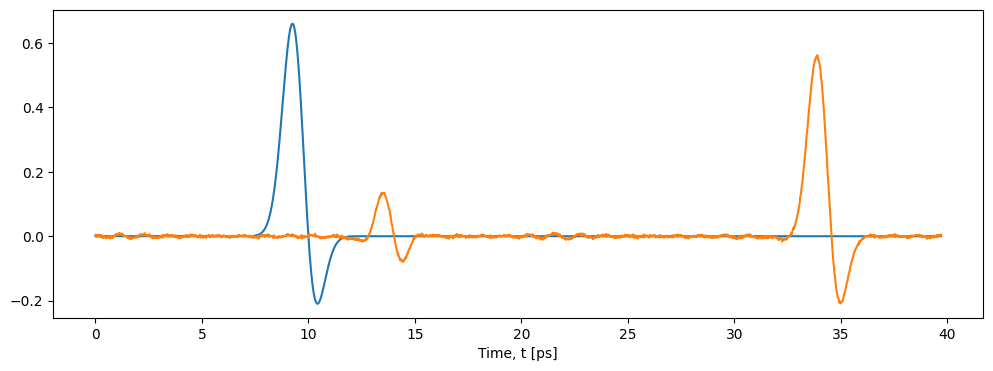

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**11  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n = 3.46
k = 0.01

# Experimental material parameters (ground truth)
material_params_exp = [(n+1j*k, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

## Extract n & k for known D (thickness)

In [3]:
n_init, k_init, D = 3.40, 0.015, 3e-3
TDE = TimeDomainExtractorNK(reference_pulse, experimental_pulse, deltat, n_init, k_init, D, lr=0.001)
optimized_n, optimized_k = TDE.optimize(num_iterations=150, updates=10)

initial_params = [(n_init + 1j*k_init, D)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Iteration 0, Loss: 0.009874086827039719, n: 3.3990001678466797, k: 0.0139999995008111
Iteration 10, Loss: 0.0071633909828960896, n: 3.4003536701202393, k: 0.004750625230371952
Iteration 20, Loss: 0.004963702987879515, n: 3.408561944961548, k: -0.0031589448917657137
Iteration 30, Loss: 0.003636708715930581, n: 3.417191982269287, k: -0.00856771506369114
Iteration 40, Loss: 0.0027881264686584473, n: 3.4252524375915527, k: -0.011475890874862671
Iteration 50, Loss: 0.0021924907341599464, n: 3.4325313568115234, k: -0.012278782203793526
Iteration 60, Loss: 0.0017108246684074402, n: 3.4390368461608887, k: -0.011424201540648937
Iteration 70, Loss: 0.0013123296666890383, n: 3.4448225498199463, k: -0.009285272099077702
Iteration 80, Loss: 0.0009403153671883047, n: 3.4499199390411377, k: -0.006148356944322586
Iteration 90, Loss: 0.0006073784898035228, n: 3.454296350479126, k: -0.0022328479681164026
Iteration 100, Loss: 0.0003137866733595729, n: 3.4578137397766113, k: 0.0022636367939412594
Iteratio

[((3.4597673416137695+0.009998660534620285j), 0.003)]


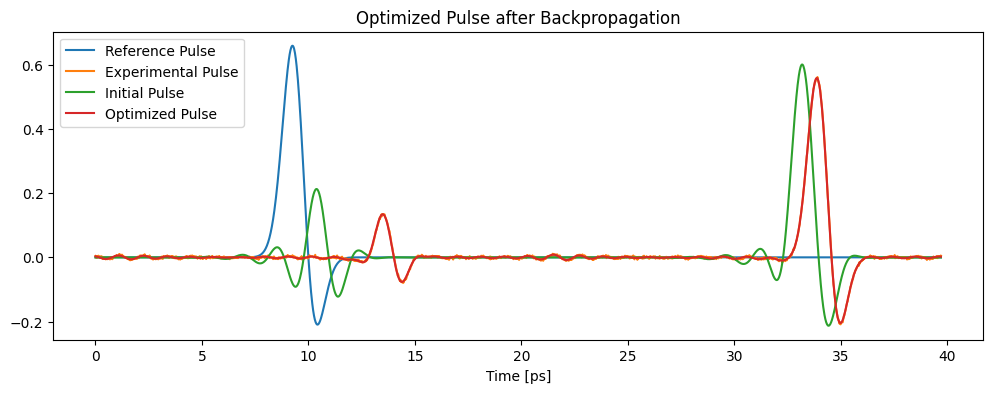

In [4]:
best_params = [(optimized_n + 1j*optimized_k, D)]
# TODO: find 
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

## Finding D for known n & k

In [5]:
D_init = 3.3 * 1e-3
TDE_D = TimeDomainExtractorD(reference_pulse, experimental_pulse, deltat, n, k, D_init, lr=0.01)
optimized_D = TDE_D.optimize(num_iterations=150, updates=10, alpha=1)

initial_params = [(n + 1j*k, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Iteration 0, Loss: 0.01379982940852642, D: 0.003267163410782814
Iteration 10, Loss: 0.010643457062542439, D: 0.0033823673147708178
Iteration 20, Loss: 0.011001721024513245, D: 0.0033737753983587027
Iteration 30, Loss: 0.010636022314429283, D: 0.003373493906110525
Iteration 40, Loss: 0.010668077506124973, D: 0.0033750240691006184
Iteration 50, Loss: 0.010659852996468544, D: 0.003374972380697727
Iteration 60, Loss: 0.010625118389725685, D: 0.0033750690054148436
Iteration 70, Loss: 0.010634854435920715, D: 0.0033757900819182396
Iteration 80, Loss: 0.010625941678881645, D: 0.0033753025345504284
Iteration 90, Loss: 0.01064174436032772, D: 0.0033756373450160027
Iteration 100, Loss: 0.010640313848853111, D: 0.003375416621565819
Iteration 110, Loss: 0.01065761037170887, D: 0.0033754922915250063
Iteration 120, Loss: 0.01064582820981741, D: 0.0033755761105567217
Iteration 130, Loss: 0.010634440928697586, D: 0.0033755390904843807
Iteration 140, Loss: 0.010633276775479317, D: 0.0033754827454686165

[((3.46+0.01j), 0.003375333035364747)]


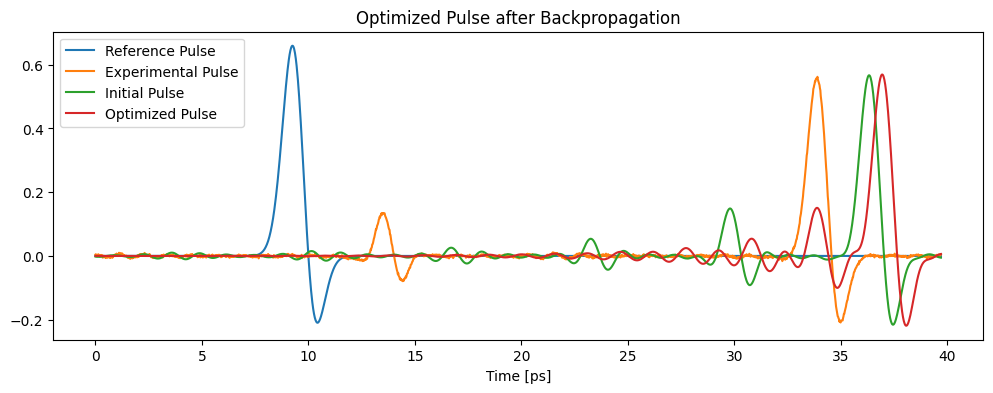

In [6]:
best_params = [(n + 1j*k, optimized_D)]
# TODO: find 
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()